# Explore the Candy Crush dataset

The dataset contains one week of data from a sample of players who played Candy Crush back in 2014. The data is also from a single episode, that is, a set of 15 levels. It has the following columns:

* player_id: a unique player id
* dt: the date
* level: the level number within the episode, from 1 to 15.
* num_attempts: number of level attempts for the player on that level and date.
* num_success: number of level attempts that resulted in a success/win for the player on that level and date.

The granularity of the dataset is player, date, and level. That is, there is a row for every player, day, and level recording the total number of attempts and how many of those resulted in a win.

In [2]:
# load the dataset and count the number of rows and columns
# df = ...
import pandas as pd
#import os

#os.chdir("/Users/test/Dropbox/FCUP/FCUP-Aulas/2024_2025/IntroDataScience/datasets/")
# Load the 'ransom.csv' into a DataFrame
df = pd.read_csv('candy_crush.csv')

In [3]:
# Count and display the number of unique players
print("Number of unique players: ")
print(len(df["player_id"].unique()))

# Display the date range of the data. 
# To check the range of dates in a column of a Pandas DataFrame, you can use the min() and max() functions, just like you would for numerical data. However, you'll need to ensure that the column is of a date or datetime data type.

print("\n")
print(df.info())

print("\nDate range: ")
print(min(df["dt"]))
print(max(df["dt"]))

Number of unique players: 
6814


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16865 entries, 0 to 16864
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   player_id     16865 non-null  object
 1   dt            16865 non-null  object
 2   level         16865 non-null  int64 
 3   num_attempts  16865 non-null  int64 
 4   num_success   16865 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 658.9+ KB
None

Date range: 
2014-01-01
2014-01-07


# Computing level difficulty
Within each Candy Crush episode, there is a mix of easier and tougher levels. Luck and individual skill make the number of attempts required to pass a level different from player to player. The assumption is that difficult levels require more attempts on average than easier ones. That is, the harder a level is, the lower the probability to pass that level in a single attempt is.

A simple approach to model this probability is as a Bernoulli process; as a binary outcome (you either win or lose) characterized by a single parameter $Pwin$: the probability of winning the level in a single attempt. This probability can be estimated for each level as:

$Pwin = \frac{Sum (wins)}{Sum (attempts)}$

For example, let's say a level has been played 10 times and 2 of those attempts ended up in a victory. Then the probability of winning in a single attempt would be pwin = 2 / 10 = 20%.

Now, let's compute the difficulty Pwin separately for each of the 15 levels.

In [4]:
# iterate over all levels and calculate the ratio # success / # attempts
levels = df.level.unique()
levels.sort()

pwin = []

for level in levels:
    wins = df[df["level"] == level].num_success
    attempts = df[df["level"] == level].num_attempts
    pwin.append(sum(wins)/sum(attempts))


pwn_df = pd.DataFrame({'level': levels, 'pwin' : pwin })
print(pwn_df)


    level      pwin
0       1  0.618759
1       2  0.518288
2       3  0.428202
3       4  0.372425
4       5  0.091394
5       6  0.419862
6       7  0.135661
7       8  0.040529
8       9  0.081301
9      10  0.187995
10     11  0.108161
11     12  0.095952
12     13  0.516956
13     14  0.280303
14     15  0.038092


Text(0, 0.5, 'Probability of winning')

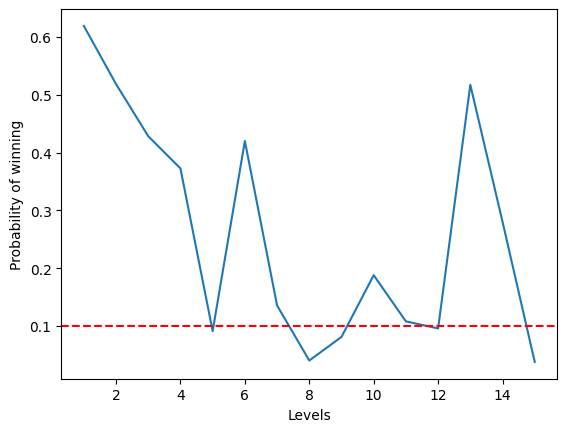

In [5]:
# plot the difficulty profile for all levels
# choose the most appropriate type of visualization
from matplotlib import pyplot as plt
plt.plot(levels, pwin)

# Add a horizontal dashed line at y=25
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel("Levels")
plt.ylabel("Probability of winning")

# Compute Uncertainty
As Data Scientists we should always report some measure of the uncertainty of any provided numbers. Maybe tomorrow, another sample will give us slightly different values for the difficulties! Here we will simply use the Standard error as a measure of uncertainty:

$S_{error} = \frac{σ_{sample}}{\sqrt{n}}$

Here $n$ is the number of datapoints and $S$ sample is the sample standard deviation. For a Bernoulli process, the sample standard deviation is:

$S_{sample} = \sqrt{p_{win}(1-p_{win})}$

Therefore, we can calculate the standard error like this:

$S_{error} = \sqrt{\frac{p_{win}(1-p_{win})}{n}}$

We already have all we need in the difficulty data frame! Every level has been played n number of times and we have their difficulty $p_{win}$. Now, let's calculate the standard error for each level.

[8.921943712559246e-05, 9.714612892338567e-05, 7.918661710036854e-05, 6.173390084845345e-05, 5.985376661002041e-06, 7.654866638253146e-05, 1.2953692182483578e-05, 1.2293251443718663e-06, 4.531670356288505e-06, 2.3256087435816825e-05, 8.651348785755117e-06, 6.315187062019973e-06, 9.408911443243587e-05, 3.638766982430894e-05, 6.031606742374814e-07]


Text(0.5, 0, 'Levels')

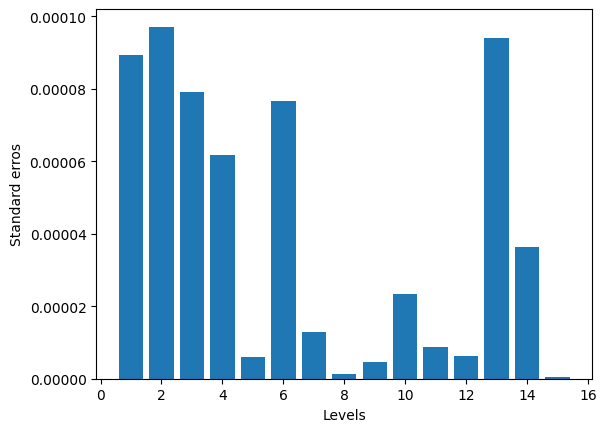

In [6]:
# Compute the standard error of p_win for each level

std_error = []

for level in levels:
    n = sum(df[df["level"] == level].num_attempts)
    error = ((pwin[level-1] * (1 - pwin[level-1])) / n)**1/2
    std_error.append(error)

# Create a barplot with standard errors
print(std_error)
plt.bar(levels, std_error)
plt.ylabel("Standard erros")
plt.xlabel("Levels")

# Estimating probabilities of winning
One question a level designer might ask is: *How likely is it that a player will reach a level without losing a single time?* 

Let's calculate this using the estimated level difficulties!

Recall that the probability of two independent events happening is simply the product of the individual probabilities. 
So the probability of winning both level 1 and level 2 on the first attempt would be:
$p_win[1] * p_win[2]$

To extend this to all level $Y$ you can use the multiplicatio all the numbers in a vector together

In [11]:
# create a function that given the level calculates the probability of reaching that level without loosing.
import numpy as np
# until level 5
print(np.prod(pwin[0:5]))

# develop a function that allows you to calculate the likelihood up to level $n$
def prob_win_first_attempt(level):
    return np.prod(pwin[0:level])

print(prob_win_first_attempt(7))

0.0046740947976839945
0.00026623038527028356
